# Model Prep & Experiments

In [ ]:
'''This notebook loads, explores, and visualizes the revenue prediction dataset'''

__author__ = 'Jaime Garvey'
__email__ = 'jaimemgarvey@gmail.com'

In [709]:
import pickle
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rcParams
import plotly.graph_objects as go
import plotly.express as px 
from plotly.subplots import make_subplots
import seaborn as sns

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
import statsmodels.tsa.stattools as ts
from statsmodels.graphics import tsaplots
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.arima.model import ARIMA

from sklearn.linear_model import LinearRegression,RANSACRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, TimeSeriesSplit,GridSearchCV
from sklearn.metrics import mean_squared_error
import pmdarima as pm
from pmdarima.utils import diff_inv
import stan #pystan
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

import itertools
import re

import nest_asyncio
nest_asyncio.apply()
import sys
import os
import warnings
warnings.filterwarnings("ignore") 

In [132]:
#load data
search_df = pd.read_pickle('../data/processed/search_df_select.pkl')
search_df.head(2)

revenue  google_search_Bottom  google_search_Mid  \
date                                                            
2019-01-01  30638.84                248.73               0.27   
2019-01-02  30134.13                209.05               1.94   

            google_search_Top  bing_search_Bottom  bing_search_Top  \
date                                                                 
2019-01-01            1286.40               17.23        49.940000   
2019-01-02            1243.62               18.18        59.969999   

            facebook_Bottom  facebook_Mid  facebook_Top   google       bing  \
date                                                                          
2019-01-01           121.58        220.94       5416.81  1535.40  67.170000   
2019-01-02           120.67        216.65       5711.90  1454.61  78.149999   

            facebook          top     mid  bottom  total_spend  
date                                                            
2019-01-01   5759.33  6753.150000  221.21  387.54  7361.900000  
2019-01-02   6049.22  7015.489999  218.59  347.90  7581.979999

In [133]:
#resample weekly
weekly_avg =search_df.resample('W-MON').mean()
# weekly = weekly_avg.reset_index()
# weekly.to_csv('../data/processed/weekly.csv', index=False)

# Explore Data Properties

## Visualize Revenue Time Series

In [16]:
fig = make_subplots(rows=2, cols=1, subplot_titles=('Daily', 'Weekly'))

fig.add_trace(go.Scatter(x=search_df.index, y=search_df['revenue']),row=1, col=1)

fig.add_trace(go.Scatter(x=weekly_avg.index, y=weekly_avg.revenue), row=2, col=1)

# fig.add_trace(go.Scatter(x=monthly_avg.index, y=monthly_avg.revenue), row=3, col=1)

fig.update_layout(height=600, width=1000, title_text="Revenue Time Series")
fig.show()

## Decompose 

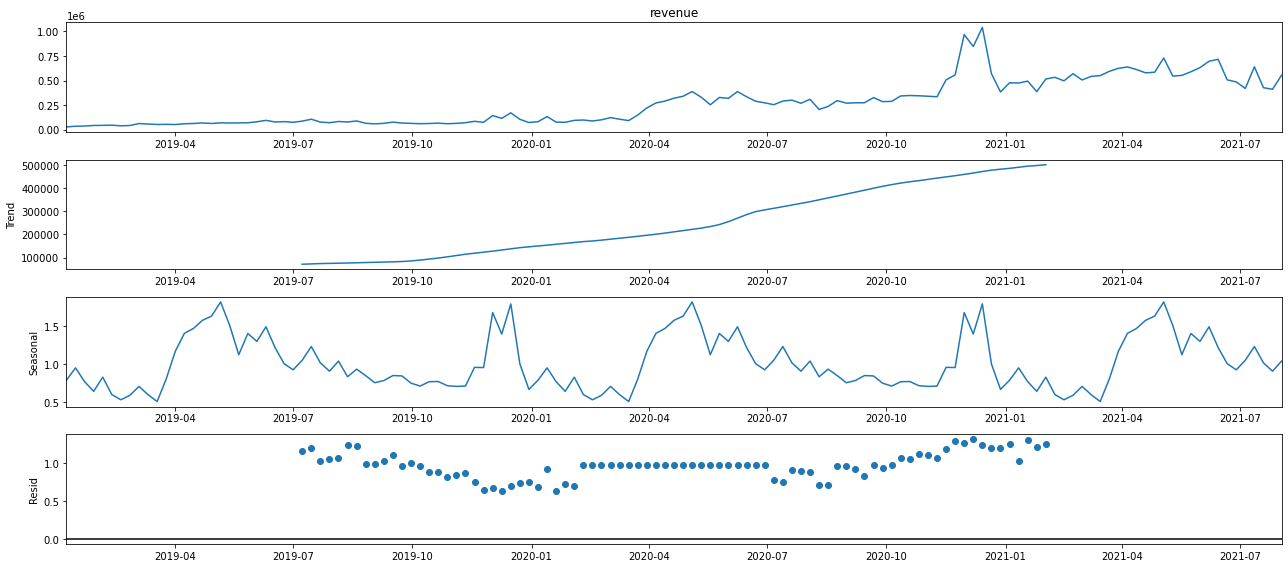

In [17]:
decomposition = sm.tsa.seasonal_decompose(weekly_avg['revenue'], model='multiplicative')
rcParams["figure.figsize"] = 18, 8

decomposition.plot();

## Check Autocorrelation & Partial Coorelation

/Users/Jaime/miniconda3/envs/rev_predict/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



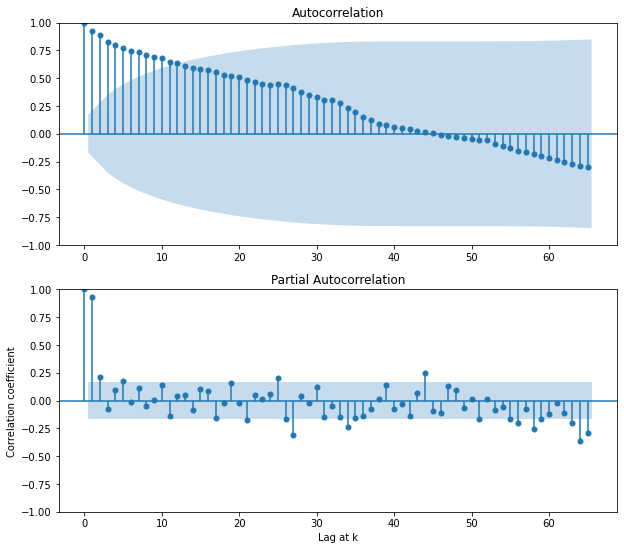

In [18]:
fig, ax = plt.subplots(2,1,figsize=(10,9))
tsaplots.plot_acf(weekly_avg.revenue, lags=65, ax=ax[0])
tsaplots.plot_pacf(weekly_avg.revenue, lags=65, ax=ax[1])

plt.xlabel("Lag at k")
plt.ylabel("Correlation coefficient")
plt.show()

The autocorrelation plot shows more evidence of the data not being stationary and having trend. There is also some reason to suspect annual seasonality (around lags 28 and 65). 

## Check Stationarity

We suspect non-stationary data but let's test for it as a sanity check. 

In [19]:
# define Dickey-Fuller Test (DFT) function
def dftest(timeseries, signif = 0.05, viz=True):
    dftest = ts.adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    if dftest[1] <= signif: #p-value <= signif
        print(f" => P-Value = {dftest[1]}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {dftest[1]}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")   
    
    
    if viz:
        #Determine rolling statistics
        rolmean = timeseries.rolling(window=12).mean()
        rolstd = timeseries.rolling(window=12).std()
    
        #Plot rolling statistics:
        orig = plt.plot(timeseries, color='blue',label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean')
        std = plt.plot(rolstd, color='black', label = 'Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean and Standard Deviation')
        plt.show(block=False)

Test Statistic           -1.027599
p-value                   0.743066
Lags Used                 6.000000
Observations Used       128.000000
Critical Value (1%)      -3.482501
Critical Value (5%)      -2.884398
Critical Value (10%)     -2.578960
dtype: float64
 => P-Value = 0.7430655866156028. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


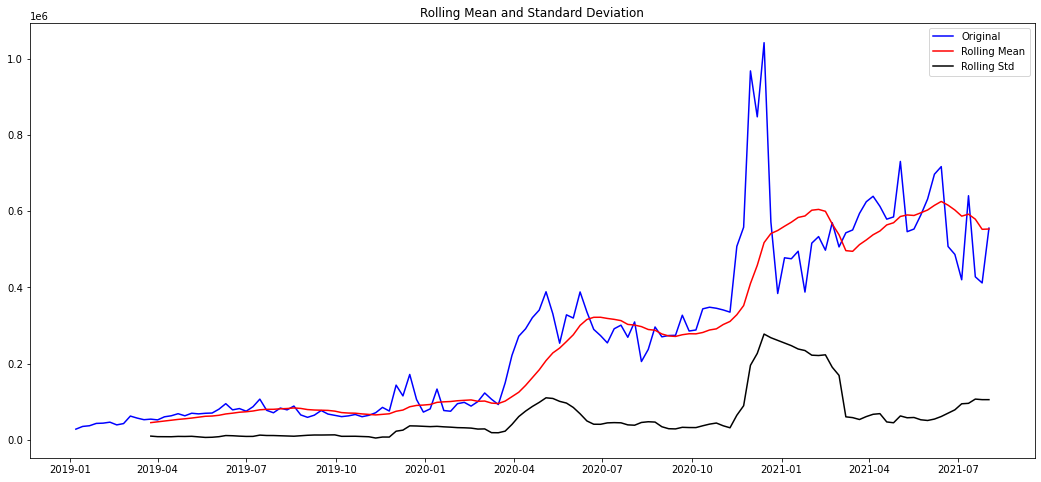

In [20]:
#test weekly
dftest(weekly_avg.revenue, False)

In [21]:
#check other variables
for name, column in weekly_avg.iteritems():
    print(f'DF Test Result for {name}')
    dftest(weekly_avg[name],signif=0.05, viz =False)
    print('\n')

DF Test Result for revenue
Test Statistic           -1.027599
p-value                   0.743066
Lags Used                 6.000000
Observations Used       128.000000
Critical Value (1%)      -3.482501
Critical Value (5%)      -2.884398
Critical Value (10%)     -2.578960
dtype: float64
 => P-Value = 0.7430655866156028. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


DF Test Result for google_search_Bottom
Test Statistic           -1.254690
p-value                   0.649638
Lags Used                 1.000000
Observations Used       133.000000
Critical Value (1%)      -3.480500
Critical Value (5%)      -2.883528
Critical Value (10%)     -2.578496
dtype: float64
 => P-Value = 0.6496383985095804. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


DF Test Result for google_search_Mid
Test Statistic           -1.080117
p-value                   0.722935
Lags Used                 0.000000
Observations Used       134.000000
Critical Value

Test Statistic           -2.556795
p-value                   0.102260
Lags Used                12.000000
Observations Used       122.000000
Critical Value (1%)      -3.485122
Critical Value (5%)      -2.885538
Critical Value (10%)     -2.579569
dtype: float64
 => P-Value = 0.10225963086996931. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


DF Test Result for seas_Is_year_end
Test Statistic                 NaN
p-value                        NaN
Lags Used                 0.000000
Observations Used       134.000000
Critical Value (1%)      -3.480119
Critical Value (5%)      -2.883362
Critical Value (10%)     -2.578407
dtype: float64
 => P-Value = nan. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


DF Test Result for seas_Is_year_start
Test Statistic                 NaN
p-value                        NaN
Lags Used                 0.000000
Observations Used       134.000000
Critical Value (1%)      -3.480119
Critical Value (5%)    

/Users/Jaime/miniconda3/envs/rev_predict/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:926: RuntimeWarning:

divide by zero encountered in log

/Users/Jaime/miniconda3/envs/rev_predict/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:926: RuntimeWarning:

divide by zero encountered in log

/Users/Jaime/miniconda3/envs/rev_predict/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:926: RuntimeWarning:

divide by zero encountered in log



As we suspect, neither the target variable (revenue) nor the features are stationary. How we deal with this depends on the modeling approach.

# Variable Transformations

## Generate & Split Features

### Helper Functions

In [8]:
#lags
def prepareData(series, lag_start, lag_end):
    # copy of the initial dataset
    data = pd.DataFrame(series.copy())
    name = series.name
    data.columns = [name]
    
    # lags of series
    for i in range(lag_start, lag_end):
        data["{}_lag_{}".format(name,i)] = data[name].shift(i)
    return data

In [9]:
# Create Date features
def add_datepart(df, fldname, drop=True):
    '''
    fast ai function 
    '''     
    fld = df[fldname]
    if not np.issubdtype(fld.dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, 
                                     infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    for n in ('Year', 'Month', 'Week', 'Day', 'Dayofweek', 
            'Dayofyear', 'Is_month_end', 'Is_month_start', 
            'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 
            'Is_year_start'):
        df['seas_'+targ_pre+n] = getattr(fld.dt,n.lower())

In [415]:
def apply_mean_center(x):
    mu = np.mean(x)
    xm = x/mu
    return xm, mu

def mean_center_trandform(df, cols):
    df_new = pd.DataFrame(index=df.index)
    sc = {}
    for col in cols:
        x = df[col].values
        df_new[col], mu = apply_mean_center(x)
        sc[col] = mu
    return df_new, sc

def mean_log1p_transform(df, cols):
    df_new = pd.DataFrame(index=df.index)
    sc = {}
    for col in cols:
        x = df[col].values
        xm, mu = apply_mean_center(x)
        sc[col] = mu
        df_new[col] = np.log1p(xm)
    return df_new, sc

def log_trans_df(df, cols):
    for col in cols:
        df['ln_'+col] = np.log1p(df[col])
    return df

def diff_df(df):
    return df.diff().dropna()

# reverse to get back to real values

def revese_transform(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

### Generate Features

In [134]:
var_cols = {
    #media spend
    'media' : ['google_search_Bottom', 'google_search_Mid',
       'google_search_Top', 'bing_search_Bottom', 'bing_search_Top',
       'facebook_Bottom', 'facebook_Mid', 'facebook_Top'],
    'media_grp' : ['google', 'bing', 'facebook', 'top', 'mid', 'bottom'],
    
    #control
    'seas' : [col for col in weekly_avg.columns if 'seas_' in col],
    
    #revenue (target)
    'rev' : ['revenue']
}

In [135]:
# log transformed variables
weekly_avg = log_trans_df(weekly_avg, var_cols['media'] + var_cols['media_grp'] + var_cols['rev'] )

#mean centered & log_trans
wk_stdln, mu_dict = mean_log1p_transform(weekly_avg, var_cols['media'] + var_cols['media_grp'] + var_cols['rev'])

# differenced
differenced = diff_df(weekly_avg)
wk_stdlnd = diff_df(wk_stdln)

# create date/seasonality features
date_features = pd.DataFrame(weekly_avg.index, columns=['date'])
add_datepart(date_features,'date')
date_features.set_index('date', inplace=True)
weekly_avg = pd.merge(weekly_avg, date_features, left_index=True, right_index=True)


/var/folders/7q/jt7tr6xn72dcjsr_4kqdp6lc0000gn/T/ipykernel_25380/1635438555.py:15: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



In [153]:
#add seasonal columns
var_cols['seas'] = [col for col in weekly_avg.columns if 'seas_' in col]
var_cols['ln'] = [col for col in weekly_avg.columns if 'ln_' in col]
var_cols['ln_mg'] = ['ln_' + col for col in var_cols['media_grp']]
var_cols['ln_m'] = ['ln_' + col for col in var_cols['media']]

## Check Stationarity of Transformed Features

We have a few options to make our data stationary. In this case we will explore differencing and log transformations.

In [22]:
# check log transformation

log_trans = weekly_avg[var_cols['ln']]

for name, column in log_trans.iteritems():
    print(f'DF Test Result for {name}')
    dftest(log_trans[name],signif=0.05, viz =False)
    print('\n')

DF Test Result for ln_google_search_Bottom
Test Statistic           -0.858379
p-value                   0.801370
Lags Used                 5.000000
Observations Used       129.000000
Critical Value (1%)      -3.482088
Critical Value (5%)      -2.884219
Critical Value (10%)     -2.578864
dtype: float64
 => P-Value = 0.8013696396748056. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


DF Test Result for ln_google_search_Mid
Test Statistic           -1.516179
p-value                   0.525493
Lags Used                 0.000000
Observations Used       134.000000
Critical Value (1%)      -3.480119
Critical Value (5%)      -2.883362
Critical Value (10%)     -2.578407
dtype: float64
 => P-Value = 0.5254929851337126. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


DF Test Result for ln_google_search_Top
Test Statistic           -2.561889
p-value                   0.101133
Lags Used                 1.000000
Observations Used       133.00

In [23]:
# check other variables (Does first order differencing make features stationary?)

for name, column in differenced.iteritems():
    print(f'DF Test Result for {name}')
    dftest(differenced[name],signif=0.05, viz =False)
    print('\n')

DF Test Result for revenue
Test Statistic         -6.452058e+00
p-value                 1.514919e-08
Lags Used               5.000000e+00
Observations Used       1.280000e+02
Critical Value (1%)    -3.482501e+00
Critical Value (5%)    -2.884398e+00
Critical Value (10%)   -2.578960e+00
dtype: float64
 => P-Value = 1.5149188174537805e-08. Rejecting Null Hypothesis.
 => Series is Stationary.


DF Test Result for google_search_Bottom
Test Statistic         -1.279917e+01
p-value                 6.812596e-24
Lags Used               0.000000e+00
Observations Used       1.330000e+02
Critical Value (1%)    -3.480500e+00
Critical Value (5%)    -2.883528e+00
Critical Value (10%)   -2.578496e+00
dtype: float64
 => P-Value = 6.812596179235605e-24. Rejecting Null Hypothesis.
 => Series is Stationary.


DF Test Result for google_search_Mid
Test Statistic         -9.032476e+00
p-value                 5.398306e-15
Lags Used               1.000000e+00
Observations Used       1.320000e+02
Critical Value 

Test Statistic           -4.371450
p-value                   0.000333
Lags Used                 5.000000
Observations Used       128.000000
Critical Value (1%)      -3.482501
Critical Value (5%)      -2.884398
Critical Value (10%)     -2.578960
dtype: float64
 => P-Value = 0.0003333373253695669. Rejecting Null Hypothesis.
 => Series is Stationary.


DF Test Result for ln_google
Test Statistic         -1.015433e+01
p-value                 7.801456e-18
Lags Used               0.000000e+00
Observations Used       1.330000e+02
Critical Value (1%)    -3.480500e+00
Critical Value (5%)    -2.883528e+00
Critical Value (10%)   -2.578496e+00
dtype: float64
 => P-Value = 7.801456037488674e-18. Rejecting Null Hypothesis.
 => Series is Stationary.


DF Test Result for ln_bing
Test Statistic         -1.007025e+01
p-value                 1.264553e-17
Lags Used               1.000000e+00
Observations Used       1.320000e+02
Critical Value (1%)    -3.480888e+00
Critical Value (5%)    -2.883697e+00
Crit

Log transformed alone is not sufficient to achieve stationarity. We need first order differencing. 

### Box-cox

### Adstock

# Feature Selection

In [118]:
cols_selected = var_cols['media'] + var_cols['rev']

## Correlation 

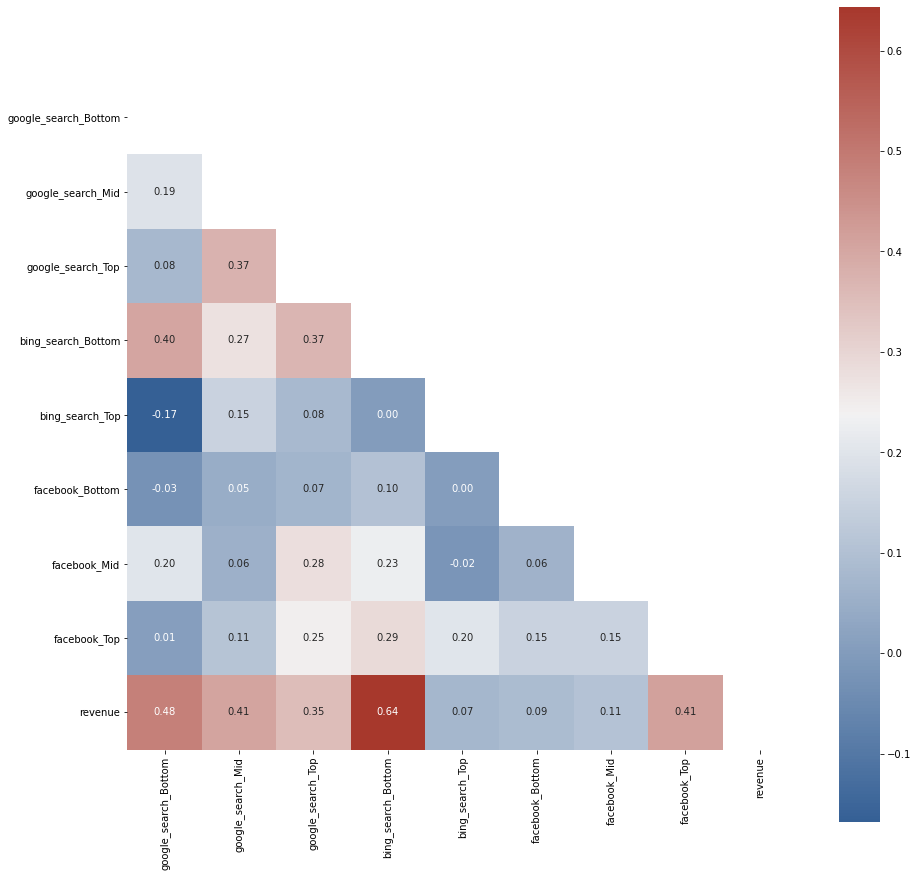

In [119]:
cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9, center="light", as_cmap=True)

# Compute corr matrix
matrix = differenced[cols_selected].corr(method="pearson")
# Create a mask
mask = np.triu(np.ones_like(matrix, dtype=bool))

fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(matrix, mask=mask, cmap=cmap, square=True, annot=True, fmt=".2f", ax=ax)
plt.show();

In [125]:
# Test for multicollinearity - VIF
features = differenced[differenced[cols_selected].columns.difference(['revenue_ln', 'revenue'])]

def vif_scores(df):
    VIF_Scores = pd.DataFrame()
    VIF_Scores["Independent Features"] = features.columns
    VIF_Scores["VIF Scores"] = [variance_inflation_factor(features.values,i) for i in range(features.shape[1])]
    return VIF_Scores
df1 = features.iloc[:,:-1]
vif_scores(df1)

Independent Features  VIF Scores
0    bing_search_Bottom    1.503708
1       bing_search_Top    1.108803
2       facebook_Bottom    1.037648
3          facebook_Mid    1.151459
4          facebook_Top    1.200606
5  google_search_Bottom    1.330002
6     google_search_Mid    1.256635
7     google_search_Top    1.388151

## Pairplots

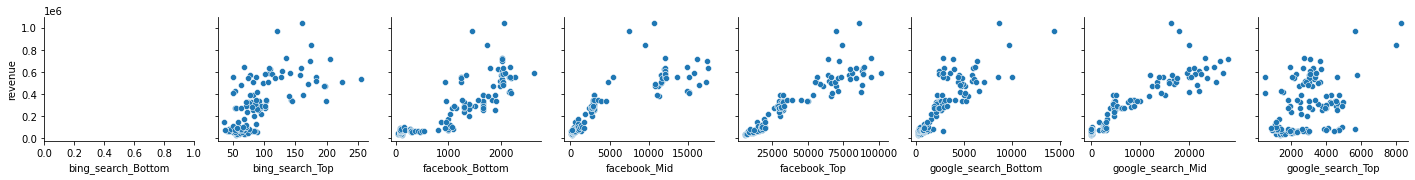

In [148]:
temp = weekly_avg[var_cols['media'] + var_cols['rev']]

sns.pairplot(temp, y_vars='revenue', x_vars=temp.columns.difference(['revenue']))

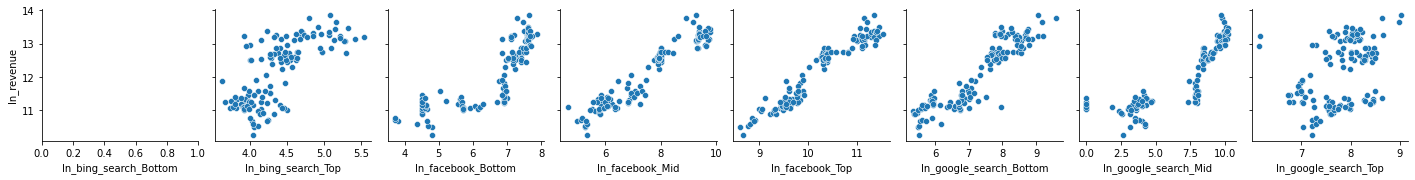

In [155]:
#log-log model
temp = weekly_avg[var_cols['ln_m'] + ['ln_revenue']]
sns.pairplot(temp, y_vars='ln_revenue', x_vars=temp.columns.difference(['ln_revenue']))


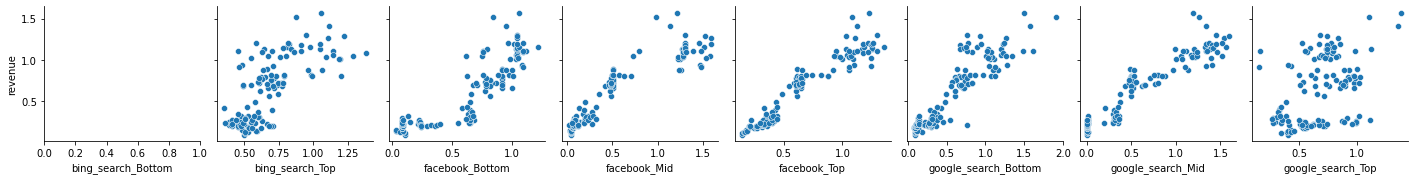

In [159]:
#log-log model
temp = wk_stdln[var_cols['media'] + ['revenue']]
sns.pairplot(temp, y_vars='revenue', x_vars=temp.columns.difference(['revenue']))

While our grouped features (e.g., google, bing, facebook) were good for EDA, there was a lot more multicollinearity. We'll stick with the segmented featured for now (e.g., google_search_Top). 

## Lag Features

In [ ]:
lagged = pd.DataFrame(index=weekly_avg.index)

In [ ]:
def prepareData(series, lag_start, lag_end):
    # copy of the initial dataset
    data = pd.DataFrame(series.copy())
    name = series.name
    data.columns = [name]
    
    # lags of series
    for i in range(lag_start, lag_end):
        data["{}_lag_{}".format(name,i)] = data[name].shift(i)
    return data

In [ ]:
for col in model_df.columns.difference(['revenue_ln']):
    ser_lag = prepareData(differenced[col], 1, 3)
    lagged = pd.merge(lagged,ser_lag, left_index=True, right_index=True)

In [ ]:
lagged = lagged.dropna()

In [ ]:
lagged = lagged.merge(differenced['revenue_ln'], left_index=True, right_index=True)

# Basic Model

## Helper Functions

In [934]:
def ts_split(df=model_df, y_label='revenue', test_size=31):
    '''
    Function splits time series data.
    
    Args:
        - df (pd.DataFrame): Full dataframe with target and features
        - y_label (str): target variable name in dataframe
        - test_size: test split size
        
    Returns:
        - labels (dict): dictionary with keys 'X' and 'y' containing the respective labels
        - train_dict (dict): dictionary containing train, X train, and y train data
        - test_dict (dict):  dictionary containing test, X test, and y test data
    '''
    labels = {'X': df.columns.difference([y_label]), 'y': y_label}
    
    tscv = TimeSeriesSplit(n_splits=2, test_size=test_size)
    train_test_1, train_test_2 =tscv.split(model_df)
    split = train_test_2
    
    train = df.head(len(split[0]))
    test =df.tail(len(split[1]))
    
    X_train, y_train = train[labels['X']], train[labels['y']]
    X_test, y_test = test[labels['X']], test[labels['y']]   
    
    train_dict = {'train': train, 'X_train': X_train, 'y_train': y_train}
    test_dict = {'test': test, 'X_test': X_test, 'y_test': y_test}
    split_dict = {'labels': labels,'train': train,'test': test,}
    
    return labels, train_dict, test_dict

In [935]:
def lr_reg(df, train_dict, test_dict, y_label, X_labels):
       '''
    Function to run linear regression
    
    Args:
        - df (pd.DataFrame): Full dataframe with target and features
        - train_dict (dict): dictionary containing train, X train, and y train data
        - test_dict (dict):  dictionary containing test, X test, and y test data
        - y_label (str): target variable name in dataframe
        - X_labels (list): feature variable names in dataframe
        
    Returns:
        - results_dict (dict): dictionary with predictions, coefficients, p values, 
                            and eval metric(rmse)
    '''
    X_train, y_train = train_dict['X_train'][X_labels], train_dict['y_train']
    X_test, y_test = test_dict['X_test'][X_labels], test_dict['y_test']    
    
    results = sm.OLS(y_train, X_train).fit()
    
    results_dict = {
                    'y_pred_test': results.predict(X_test),
                    'y_pred_train': results.predict(X_train),
                    'coefficients' : results.params.values,
                    'p_values' : results.pvalues.values
    }
    
    results_dict['pred'] =  results_dict['y_pred_train'].append(results_dict['y_pred_test'])
    
    #evaluation
    results_dict['rmse'] = mean_squared_error(y_test.values, results_dict['y_pred_test'], squared=True)
    
    return results_dict

In [936]:
def plot_results(y_actual, y_pred, rmse):
    '''
    Plots model results
    
    Args:
        - y_actual (list): list of true y values
        - y_pred (list): list of predicted y values
        - rmse: model score
        
    Returns:
        - None
    
    '''
    fig = make_subplots(rows=2, cols=1,row_heights=[0.75, 0.25])
    
    fig.add_trace(
        go.Scatter(x=y_actual.index, y=y_actual.values, name="actual"),
        row=1, col=1 
        )
    fig.add_trace(
        go.Scatter(x=y_actual.index, y=y_pred.values, name='predicted'),
        row=1, col=1 
        )

    fig.add_trace(
        go.Scatter(x=y_actual.index, y=y_actual.values - y_pred.values, name='residuals'),
        row=2, col=1
    )

    fig.update_layout(height=600, width=800, title=go.layout.Title(
            text=f"Actual vs predicted <br><sup>rmse ={rmse.round(4)}</sup>",
            xref="paper",
            x=0
        ))
    fig.show()

In [937]:
def bfe(df, train_dict, test_dict, y_label, X_labels, sl=0.05):
    '''
    Backward Feature Elimination
    
    Args:
        - df (pd.DataFrame): Full dataframe with target and features
        - train_dict (dict): dictionary containing train, X train, and y train data
        - test_dict (dict):  dictionary containing test, X test, and y test data
        - y_label (str): target variable name in dataframe
        - X_labels (list): feature variable names in dataframe
        - sl (float): significance level
        
    Returns:
        - bfe_keep (list): list of feature names to keep
        - bfe_df (pd.DataFrame): dataframe with feature names and boolean values (True if keep)
    
    '''
    X_left = list(X_labels)
    
    while(len(X_left) > 0):
        p_values = lr_reg(df, train_dict, test_dict, y_label, X_left)['p_values']
        p = pd.Series(p_values, index=X_left) 
        pmax = max(p)
        i_pmax = p.idxmax()
        if (pmax > sl):
            X_left.remove(i_pmax)
        else:
            break
    bfe = pd.Series(X_labels).apply(lambda x: x in X_left)
    bfe.index = X_labels
    bfe_df = pd.DataFrame({'bfe_keep': bfe})
    bfe_keep = list(bfe_df[bfe_df['bfe_keep']==True].index.values)

    return bfe_keep, bfe_df

In [938]:
def create_pred_df(df, results_df):
    '''
    Create prediction dataframe. 
    
    Args:
        - df (pd.DataFrame): Full dataframe with target and features
        - results_df (pd.DataFrame): dataframe with x labels, coefficients, and p values
    '''
    X_labels = results_df.index
    pred_df = df[X_labels].copy()
    for x in X_labels:
        pred_df[x] = results_df['coefficient'].loc[x] * df[x]

    return pred_df

In [939]:
def inv_diff (df_orig_column,df_diff_column, periods):
    '''
    Inverse differencing
    '''
    # array w/ data[:period] & diff values [periods:]
    value = np.array(df_orig_column[:periods].tolist()+df_diff_column[periods:].tolist())

    #inverse diff array
    inv_diff_vals = diff_inv(value, periods,1 )[periods:]
    return inv_diff_vals

In [940]:
def reverse_transform(df_orig = wk_stdln, df_pred=pred_df, periods=1, mu_dict=sc):
    '''
    Revert data back to original scale.
    '''
    df_inv = pd.DataFrame(index=df_pred.index)
    columns = df_pred.columns
    for col in columns: 
        value = np.array(df_orig[col][:periods].tolist()+df_pred[col][periods:].tolist())
        inv_diff_vals = diff_inv(value, periods, 1 )[periods:]
        
        df_inv[col] = inv_diff_vals
        df_inv[col] = np.expm1(df_inv[col])
        df_inv[col] = df_inv[col] * sc[col] 
    return df_inv

In [941]:
def display_decomp_chart(pred_df):
    '''
    Plot feature decomposition
    '''
    df = pd.DataFrame((pred_df.sum() / pred_df.sum().sum()),columns=['contribution']).rename_axis('feature').reset_index()
    fig = px.bar(df, x='contribution', y='feature')
    fig.show()

In [942]:
def display_contrib_chart(pred_df):
    '''
    Plot contribution
    '''
    plot_df = pred_df.copy()
    
    # separate positive & negative values
    plot_df = plot_df[plot_df>=0].join(plot_df[plot_df<0], lsuffix="", rsuffix="_$negative")
    plot_df.rename(columns=lambda x: '-'+x.replace('_$negative','') if '_$negative' in x else x, inplace=True)
    plot_df.dropna(axis=1, how='all', inplace=True)
    
    # plot area chart
    fig = px.area(plot_df, x=plot_df.index, y=plot_df.columns, title='Contribution Time Series')
    fig.show()

## Model

In [943]:
# run linear regression with time series split
labels, train_dict, test_dict = ts_split(df=model_df, y_label='revenue', test_size=31)
results_dict = lr_reg(model_df, train_dict, test_dict, labels['y'],labels['X'] )

# show results
results_df = pd.DataFrame({'X_labels':labels['X'], 'coefficient':results_dict['coefficients'], 'p_values':results_dict['p_values']}).round(3)
results_df.set_index('X_labels', inplace=True)
results_df

coefficient  p_values
X_labels                                   
bing_search_Bottom          0.847     0.000
bing_search_Top            -0.073     0.346
facebook_Bottom            -0.090     0.338
facebook_Mid               -0.125     0.456
facebook_Top                0.464     0.015
google_search_Bottom        0.085     0.224
google_search_Mid          -0.047     0.744
google_search_Top           0.071     0.211

In [944]:
plot_results(model_df[labels['y']], results_dict['pred'], results_dict['rmse'])

In [945]:
#backwards feature eliminatation
bke_keep, bfe_df= bfe(model_df, train_dict, test_dict, labels['y'], labels['X'], sl=0.05) #df, train_dict, test_dict, y_label, X_labels
print(bke_keep)
bfe_df

['bing_search_Bottom', 'facebook_Top']


bfe_keep
bing_search_Bottom        True
bing_search_Top          False
facebook_Bottom          False
facebook_Mid             False
facebook_Top              True
google_search_Bottom     False
google_search_Mid        False
google_search_Top        False

In [946]:
pred_df = create_pred_df(model_df, results_df) #prediction df

df_inv = reverse_transform() #invert transform data

In [947]:
display_decomp_chart(df_inv) #plot decomposition of predictors

In [948]:
display_contrib_chart(df_inv)

# Time Series Analysis

In [853]:
#Apply selected
model_df = wk_stdlnd[var_cols['media'] + ['revenue']]

In [854]:
train_test_split_date = '2021-01-01'
train = model_df[model_df.index<train_test_split_date] #2019 & 2020
test = model_df[model_df.index>=train_test_split_date] #2021

X_train, y_train = train[train.columns.difference(['revenue'])], train['revenue']
X_test, y_test = test[test.columns.difference(['revenue'])], test['revenue']

## ARIMA

In [855]:
#Start with p = 3
# q = 3

model = ARIMA(train.revenue, order=(3,1,3))
model_fit = model.fit()
print(model_fit.summary())

# MA terms p=values are high --> need to reduce

                               SARIMAX Results                                
Dep. Variable:                revenue   No. Observations:                  103
Model:                 ARIMA(3, 1, 3)   Log Likelihood                  97.894
Date:                Thu, 11 Nov 2021   AIC                           -181.787
Time:                        06:16:43   BIC                           -163.412
Sample:                    01-14-2019   HQIC                          -174.347
                         - 12-28-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4986      0.151     -9.942      0.000      -1.794      -1.203
ar.L2         -0.7723      0.231     -3.337      0.001      -1.226      -0.319
ar.L3          0.1180      0.115      1.027      0.3

In [872]:
#Start with p = 2
# reduce to q = 0

model = ARIMA(model_df.revenue, order=(2,1,0)) #p,d,q
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                revenue   No. Observations:                  134
Model:                 ARIMA(2, 1, 0)   Log Likelihood                  93.206
Date:                Thu, 11 Nov 2021   AIC                           -180.411
Time:                        06:28:26   BIC                           -171.740
Sample:                    01-14-2019   HQIC                          -176.887
                         - 08-02-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7591      0.068    -11.121      0.000      -0.893      -0.625
ar.L2         -0.2848      0.049     -5.816      0.000      -0.381      -0.189
sigma2         0.0143      0.001     12.316      0.0

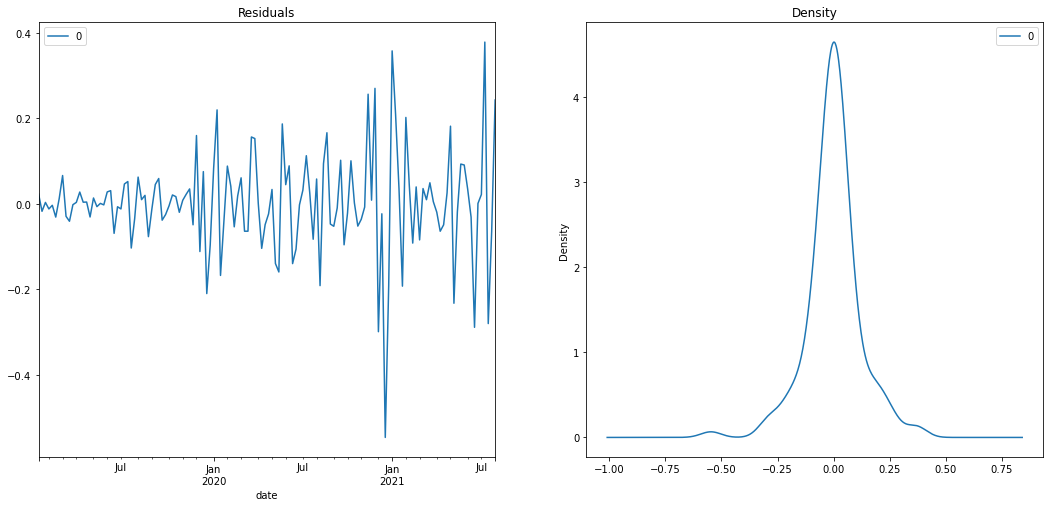

In [857]:
# plot residuals
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

residuals have near 0 mean; variance could be more uniform

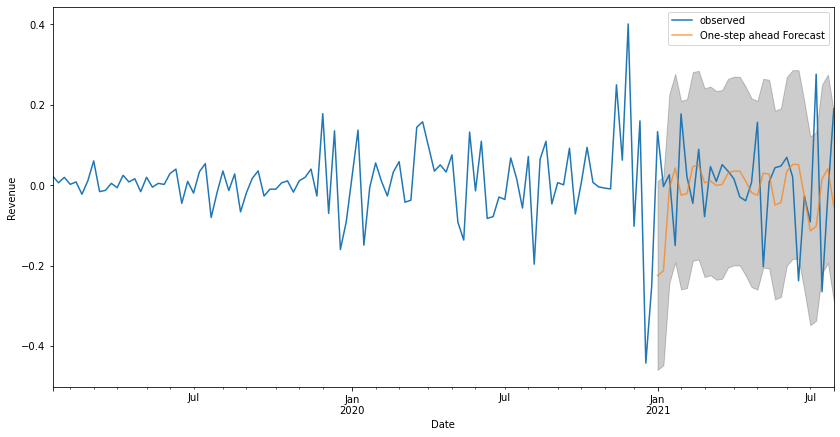

In [881]:
pred = model_fit.get_prediction(start=pd.to_datetime('2021-01-04'), end= pd.to_datetime('2021-08-02'), dynamic=False)
pred_ci = pred.conf_int()
ax = model_df.revenue.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Revenue')
plt.legend()
plt.show()

In [884]:
y_forecasted = pred.predicted_mean
y_truth = test.revenue
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 0.02
The Root Mean Squared Error of our forecasts is 0.16


## SARIMAX

In [864]:
fig = make_subplots(rows=3, cols=1, subplot_titles=('Weekly', 'Log Trans','Log Diff'))

fig.add_trace(go.Scatter(x=weekly_avg.index, y=weekly_avg.revenue), row=1, col=1)

fig.add_trace(go.Scatter(x=wk_stdln.index, y=wk_stdln.revenue.values), row=2, col=1)

fig.add_trace(go.Scatter(x=wk_stdlnd.index, y=wk_stdlnd.revenue), row=3, col=1)
fig.update_layout(height=600, width=1000, title_text="Revenue Time Series")
fig.show()

In [866]:
smodel = pm.auto_arima(model_df.revenue, start_p=1, start_q=1,
                         test='adf',
                         max_p=2, max_q=2, m=52,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[52] intercept   : AIC=inf, Time=9.22 sec
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=-134.503, Time=0.31 sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=-140.215, Time=4.00 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=inf, Time=9.38 sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=-136.463, Time=0.24 sec
 ARIMA(1,0,0)(0,1,0)[52] intercept   : AIC=-136.348, Time=0.29 sec
 ARIMA(1,0,0)(2,1,0)[52] intercept   : AIC=-138.215, Time=14.62 sec
 ARIMA(1,0,0)(1,1,1)[52] intercept   : AIC=-138.215, Time=6.06 sec
 ARIMA(1,0,0)(0,1,1)[52] intercept   : AIC=inf, Time=11.12 sec
 ARIMA(1,0,0)(2,1,1)[52] intercept   : AIC=-136.215, Time=10.34 sec
 ARIMA(0,0,0)(1,1,0)[52] intercept   : AIC=-137.433, Time=3.17 sec
 ARIMA(2,0,0)(1,1,0)[52] intercept   : AIC=-138.365, Time=10.06 sec
 ARIMA(1,0,1)(1,1,0)[52] intercept   : AIC=-138.454, Time=12.50 sec
 ARIMA(0,0,1)(1,1,0)[52] intercept   : AIC=-139.806, Time=5.10 sec
 ARIMA(2,0,1)(1,1,0)[52] inte

In [885]:
#SARIMAX(2, 0, 0)x(1, 1, [1], 52)
#AIC -34.653
smodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  134
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 52)   Log Likelihood                  74.106
Date:                            Thu, 11 Nov 2021   AIC                           -142.212
Time:                                    06:36:30   BIC                           -134.992
Sample:                                         0   HQIC                          -139.313
                                            - 134                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2444      0.099     -2.464      0.014      -0.439      -0.050
ar.S.L52      -0.4954      0.163     -3.032      0.002      -0.816      -0.175
sigma2         0.0080      0.002      4.827      0.000       0.005       0.011
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.61
Prob(Q):                              0.91   Prob(JB):                         0.74
Heteroskedasticity (H):               1.70   Skew:                            -0.19
Prob(H) (two-sided):                  0.18   Kurtosis:                         3.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

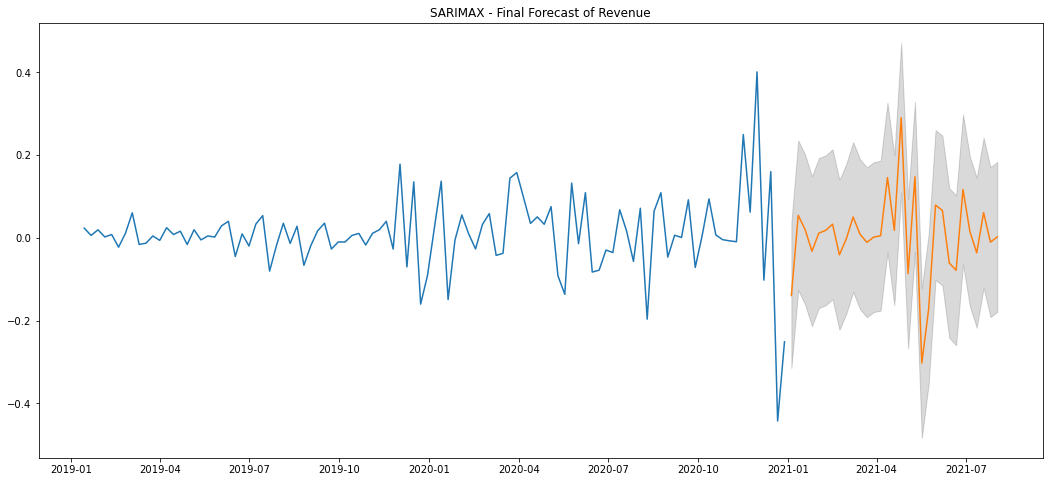

In [887]:
# Forecast
n_periods = 31
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
# index_of_fc = pd.date_range(test.index[-1], periods = n_periods, freq='W')
index_of_fc = test.index

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(train.revenue)
plt.plot(fitted_series)
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMAX - Final Forecast of Revenue")
plt.show()

In [890]:
y_truth = test.revenue.values
mse = ((fitted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))
# pred = sarima.predict(tr_end,te_end)[1:]
# print('SARIMA model MSE:{}'.format(mean_squared_error(tes,pred)))

The Mean Squared Error of our forecasts is 0.03
The Root Mean Squared Error of our forecasts is 0.17


## SARIMAX with Features

In [891]:
sxmodel = pm.auto_arima(y_train, exogenous=X_train,
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=52,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[52] intercept   : AIC=-108.839, Time=30.02 sec
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=-106.830, Time=2.23 sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=-105.832, Time=21.45 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=-110.461, Time=23.12 sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=-108.823, Time=1.53 sec
 ARIMA(0,0,1)(0,1,0)[52] intercept   : AIC=-112.462, Time=3.91 sec
 ARIMA(0,0,1)(1,1,0)[52] intercept   : AIC=-110.449, Time=29.87 sec
 ARIMA(0,0,1)(1,1,1)[52] intercept   : AIC=-108.456, Time=34.96 sec
 ARIMA(1,0,1)(0,1,0)[52] intercept   : AIC=-110.848, Time=3.92 sec
 ARIMA(0,0,2)(0,1,0)[52] intercept   : AIC=-112.115, Time=4.47 sec
 ARIMA(1,0,0)(0,1,0)[52] intercept   : AIC=-107.822, Time=4.24 sec
 ARIMA(1,0,2)(0,1,0)[52] intercept   : AIC=-111.957, Time=12.66 sec
 ARIMA(0,0,1)(0,1,0)[52]             : AIC=-114.375, Time=7.85 sec
 ARIMA(0,0,1)(1,1,0)[52]             : AIC=-112.375, Time=19.58 sec
 ARIMA(0,0,1

In [892]:
sxmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  103
Model:             SARIMAX(1, 0, 2)x(0, 1, [], 52)   Log Likelihood                  70.167
Date:                             Thu, 11 Nov 2021   AIC                           -116.334
Time:                                     06:44:41   BIC                            -93.152
Sample:                                 01-14-2019   HQIC                          -107.476
                                      - 12-28-2020                                         
Covariance Type:                               opg                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
bing_search_Bottom       0.2889      0.152      1.896      0.058      -0.010       0.587
bing_search_Top          0.0775      0.103      0.749      0.454      -0.125       0.280
facebook_Bottom          0.2359      0.075      3.160      0.002       0.090       0.382
facebook_Mid             0.3029      0.148      2.042      0.041       0.012       0.594
facebook_Top            -0.4036      0.285     -1.414      0.157      -0.963       0.156
google_search_Bottom     0.0417      0.075      0.554      0.579      -0.106       0.189
google_search_Mid        0.5993      0.137      4.375      0.000       0.331       0.868
google_search_Top        0.1934      0.058      3.322      0.001       0.079       0.308
ar.L1                   -0.5713      0.242     -2.365      0.018      -1.045      -0.098
ma.L1                   -0.0962      0.330     -0.292      0.771      -0.743       0.550
ma.L2                   -0.8375      0.258     -3.251      0.001      -1.343      -0.333
sigma2                   0.0034      0.001      2.709      0.007       0.001       0.006
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                 1.54
Prob(Q):                              0.71   Prob(JB):                         0.46
Heteroskedasticity (H):               1.40   Skew:                            -0.22
Prob(H) (two-sided):                  0.50   Kurtosis:                         2.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

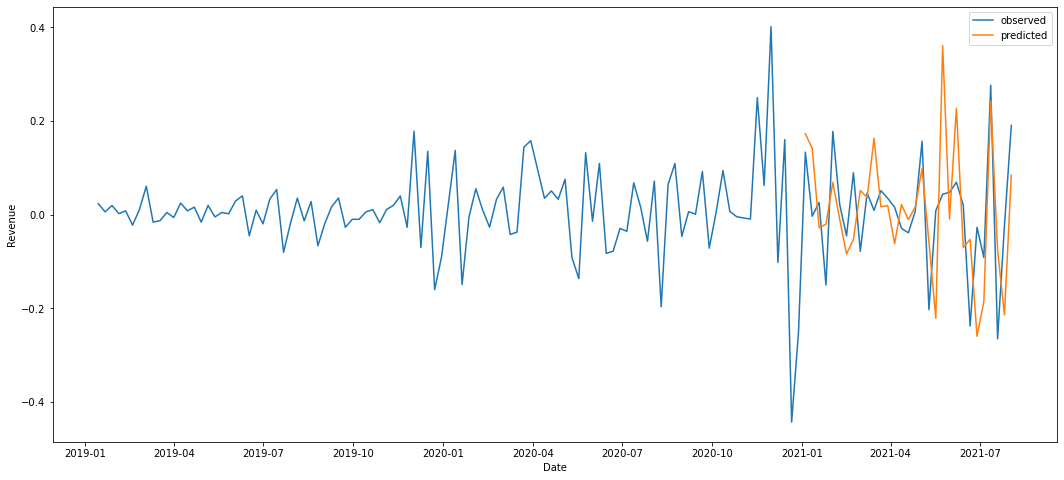

In [931]:
pred = sxmodel.predict(31, X=X_test)
t=pd.DataFrame({'pred':pred}, index=y_test.index,)
fig, ax = plt.subplots()
ax.plot(model_df.revenue,label='observed')
ax.plot(t, label='predicted')

ax.set_xlabel('Date')
ax.set_ylabel('Revenue')
plt.legend()
plt.show()

In [933]:
y_forecasted = pred
y_truth = test.revenue
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 0.02
The Root Mean Squared Error of our forecasts is 0.13


# Regression Analysis

In [372]:
#Apply selected
#seas_x = [col for col in var_cols['seas'] if col not in  ['seas_Week','seas_Day','seas_Dayofweek','seas_Dayofyear']]

model_df = wk_stdlnd[var_cols['media'] + ['revenue']]

X = model_df[var_cols['media']]
y = model_df[var_cols['rev']]

train_test_split_date = '2021-05-01'
train = model_df[model_df.index<train_test_split_date] #2019 & 2020
test = model_df[model_df.index>=train_test_split_date] #2021

X_train, y_train = train[train.columns.difference(['revenue'])], train['revenue']
X_test, y_test = test[test.columns.difference(['revenue'])], test['revenue']

### Helper Functions for Visualizations

In [384]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    if len(prediction.shape) > 1:
        prediction = prediction.reshape(-1)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)  
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=TimeSeriesSplit(), 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_squared_error(y_test.values, prediction)
    plt.title("Mean squared error {0:.4f}".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);

def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');
    
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Linear Regression

In [373]:
lr = LinearRegression()

cv_scores = cross_val_score(lr, X_train, y_train, cv=TimeSeriesSplit(3), scoring='neg_mean_squared_error')
print(f'Negative MSE: {cv_scores}')

lr.fit(X_train, y_train)
print('Coefficients:', lr.coef_)
print('Intercept:', lr.intercept_)

coef_dict = dict(list(zip(lr.feature_names_in_, lr.coef_)))

Negative MSE: [-0.00322771 -0.00733082 -0.01374431]
Coefficients: [ 0.43946882 -0.0769588   0.01855774 -0.11535787  0.54225473  0.15312952
  0.19506773  0.08294338]
Intercept: -0.001920423762114631


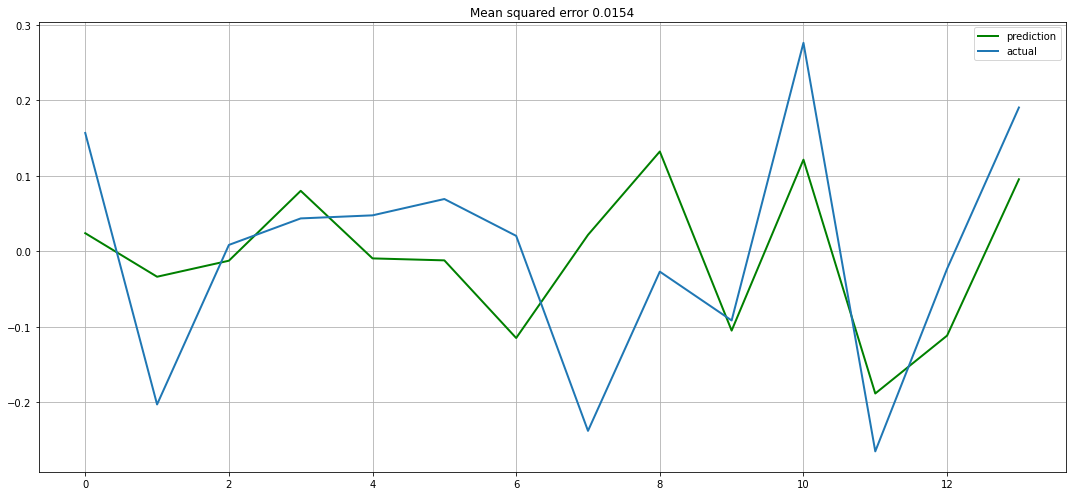

In [385]:
plotModelResults(lr)

### Residual Plot

In [388]:
#residual plot
pred = lr.predict(X_test) #.reshape(1,31)[0]
true = y_test.values
resid = true - pred

fig = px.scatter(x=true, y=pred)
fig.show()

In [396]:
fig = px.histogram(x=resid, nbins=6)
fig.show()

## RANSACR

In [399]:
model = RANSACRegressor(base_estimator=LinearRegression(), max_trials=100, loss='squared_error', random_state = 71)
model.fit(X_train, y_train)

RANSACRegressor(base_estimator=LinearRegression(), loss='squared_error',
                random_state=71)

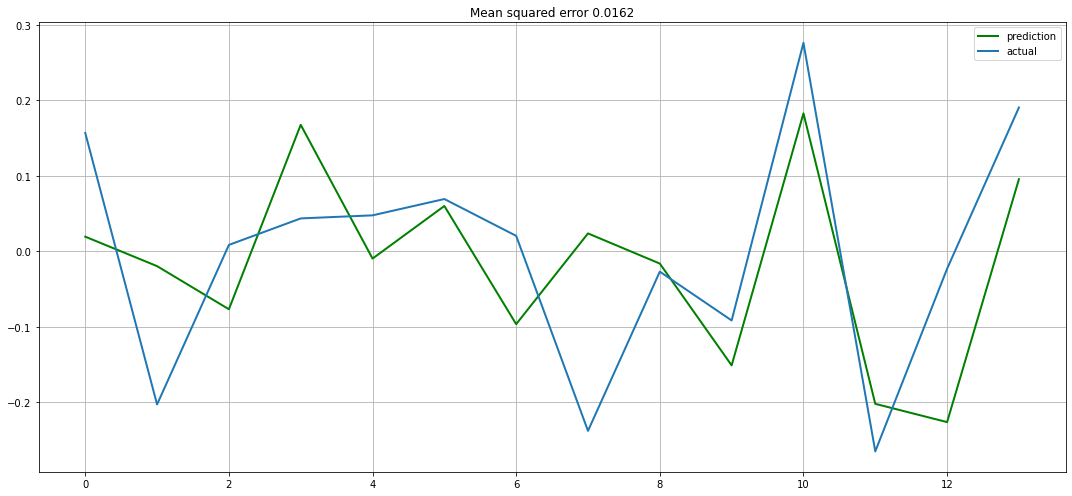

In [400]:
plotModelResults(model)

### Residual Plots

In [401]:
#residual plot
pred = model.predict(X_test)
true = y_test.values
resid = true - pred

fig = px.scatter(x=true, y=pred)
fig.show()

## GLS

In [403]:
# GLS
model = sm.GLSAR(y_train,X_train, 1)
glsar_results = model.iterative_fit(1)
print(glsar_results.summary())

                                GLSAR Regression Results                               
Dep. Variable:                revenue   R-squared (uncentered):                   0.498
Model:                          GLSAR   Adj. R-squared (uncentered):              0.461
Method:                 Least Squares   F-statistic:                              13.75
Date:                Wed, 10 Nov 2021   Prob (F-statistic):                    1.04e-13
Time:                        12:54:06   Log-Likelihood:                          154.84
No. Observations:                 119   AIC:                                     -293.7
Df Residuals:                     111   BIC:                                     -271.4
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

### Residual Plots

In [319]:
#residual plot
pred = glsar_results.predict(X_test).values
true = y_test.values
resid = true - pred

fig = px.scatter(x=true, y=pred)
fig.show()

In [320]:
fig = px.histogram(x=resid, nbins=7)
fig.show()

## Regularized with Seasonal Features

### Ridge

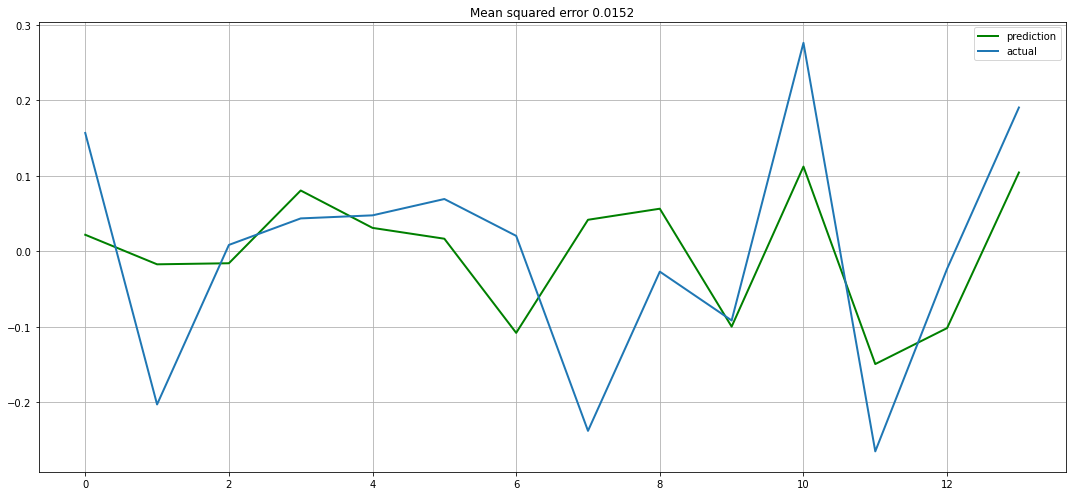

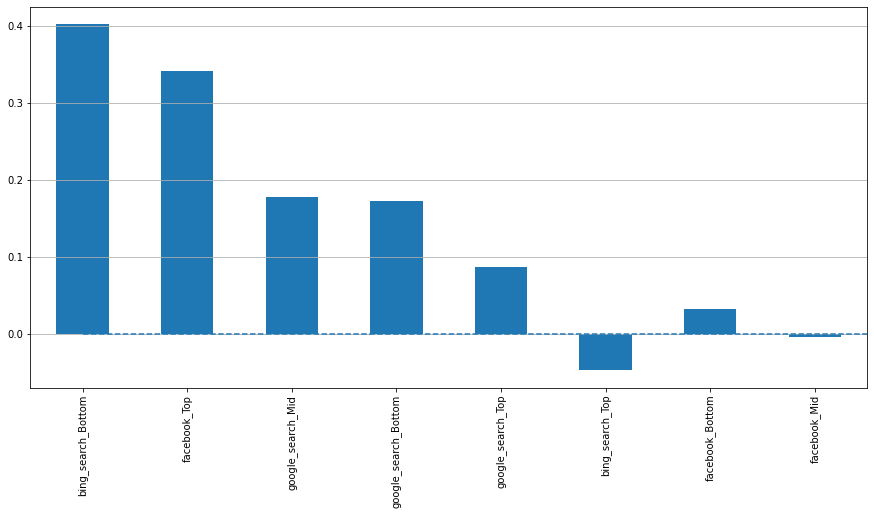

In [404]:
# Regularization
ridge = RidgeCV(cv=TimeSeriesSplit())
ridge.fit(X_train, y_train)

plotModelResults(ridge, 
                 X_train=X_train, 
                 X_test=X_test, 
                 plot_intervals=False)
plotCoefficients(ridge)

### Lasso

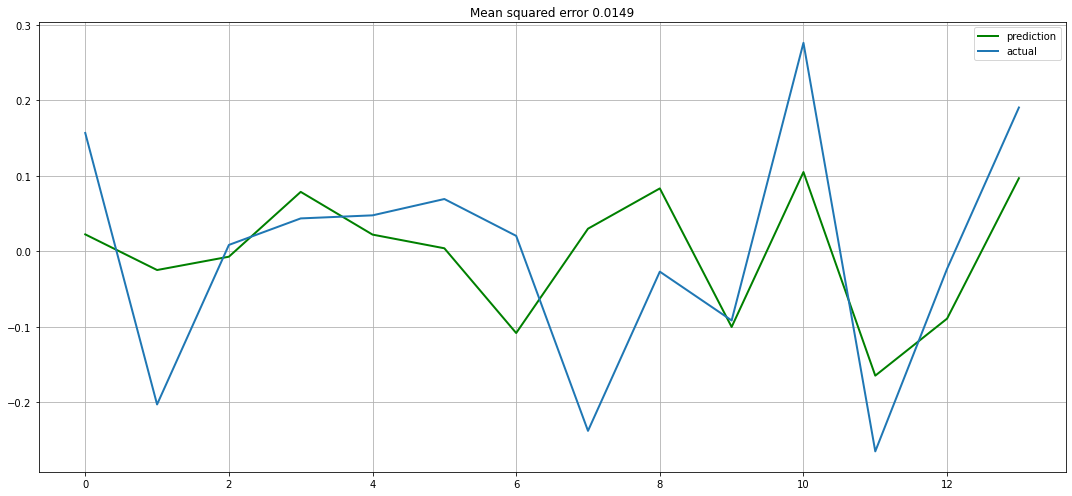

In [405]:
lasso = LassoCV(cv=TimeSeriesSplit())
lasso.fit(X_train, y_train)

plotModelResults(lasso, 
                 X_train=X_train, 
                 X_test=X_test)

### Random Forest

In [408]:
rf_reg = RandomForestRegressor(n_estimators=1000)
rf_reg.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000)

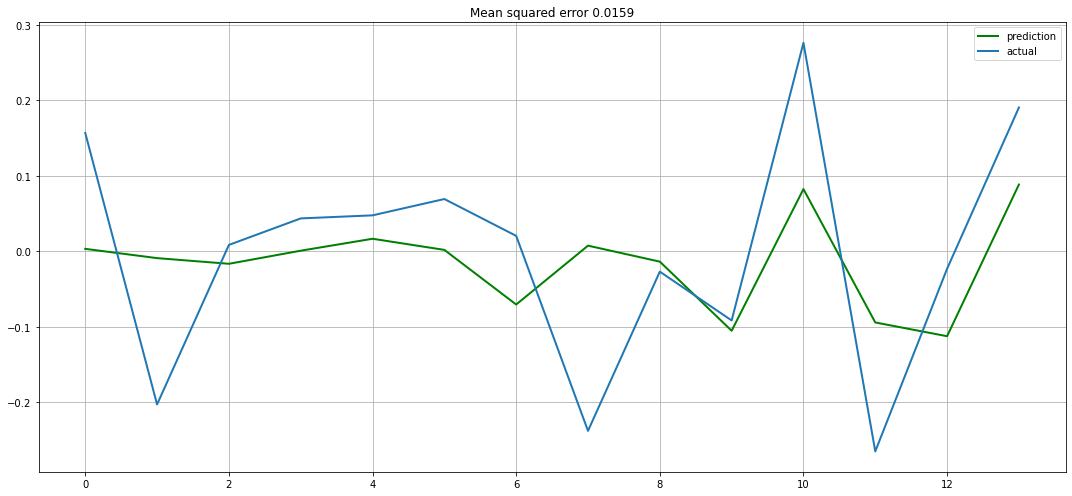

In [409]:
plotModelResults(rf_reg)

In [414]:
fig = go.Figure(data=[go.Bar(
            x=X_train.columns, y=rf_reg.feature_importances_,
#             text=rf_reg.feature_importances_,
            textposition='auto',)])

fig.show()